## `Task 1` (15 pts)

- (4 pts) An urban planner would like to choose the location $x \in \mathbb{R}^2$ for a new warehouse.
This should be close to $n$ distribution centers located at $y_1, \ldots, y_n \in \mathbb{R}^2$. The objective function to identify the location of the new warehouse is the worst-case distance.
State the optimization problem that helps to identify the proper location.
- (6 pts) Use CVXPy to solve the stated problem. If CVXPy requires reformulation of the resulting problem statement, please do it.
The data for $y_i$ are presented below and taken from the open-source dataset about locations of demand points in San Francisco. See more details [here](https://github.com/huanfachen/Open_source_location_cover_models/tree/master).
Use coordinates $y_i$ from the variable ```target_demand_points``` to identify coordinate of $y$. Plot the obtained optimal position for warehouse in the same plot as demand points.


In [36]:
import math
import random
from typing import List, Tuple

import cvxpy as cp
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


FOLDER_DATA = "./data"
FILE_SERVICE_AREAS_SHP = f"{FOLDER_DATA}/ServiceAreas_4.shp"
FILE_TREATMENT_PLANNING_MAT = f"{FOLDER_DATA}/treatment_planning_data.mat"
FILE_DEMAND_205_CENTROID_UNIFORM_CSV = f"{FOLDER_DATA}/SF_demand_205_centroid_uniform_weight.csv"


def get_points(df: pd.DataFrame) -> gpd.GeoSeries:
    return gpd.points_from_xy(df["long"], df["lat"])

def as_gdf(df: pd.DataFrame) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(df, geometry=get_points(df))

def process_df(df: pd.DataFrame, sort_by: str = "NAME") -> gpd.GeoDataFrame:
    gdf = as_gdf(df)
    if sort_by in gdf.columns:
        gdf = gdf.sort_values(by=[sort_by])
    return gdf.reset_index(drop=True)

def get_clis_geometry(clis: pd.DataFrame) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(clis['geometry'])

def plot_results_on_map(
        clis: pd.DataFrame,
        study_area: gpd.GeoDataFrame,
        zorder_clis: int = 4,
        markersize: int = 40,
        zorder_study_area: int = 1,
        figsize: tuple[int, int] = (6, 9),
    ) -> None:

    _, ax = plt.subplots(figsize=figsize)
    
    clis_processed = process_df(clis.copy())

    study_area.plot(
    ax=ax,
    alpha=0.5,
    edgecolor="k",
    facecolor="tan",
    zorder=zorder_study_area,
    )

    clis_processed.plot(
    ax=ax,
    edgecolor="k",
    zorder=zorder_clis,
    markersize=markersize,
    )

    ax.set_title("Demand Points over Study Area")
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    plt.xticks(rotation=45)
    plt.show()



In [34]:
map_area = gpd.read_file(filename=FILE_SERVICE_AREAS_SHP).dissolve()
demand_points = pd.read_csv(filepath_or_buffer=FILE_DEMAND_205_CENTROID_UNIFORM_CSV)

n_demand_points = demand_points.shape[0]
print(f"Number of demand points: {n_demand_points}")

demand_points.head()

Number of demand points: 205


,Unnamed: 0,OBJECTID,ID,NAME,STATE_NAME,AREA,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,long,lat
0,1,1,6081602900,60816029.0,California,0.48627,4135,1679,1715,112,-122.488653,37.650807
1,2,2,6081602800,60816028.0,California,0.47478,4831,1484,1506,59,-122.483550,37.659998
2,3,3,6081601700,60816017.0,California,0.46393,4155,1294,1313,55,-122.456484,37.663272
3,4,4,6081601900,60816019.0,California,0.81907,9041,3273,3330,118,-122.434247,37.662385
4,5,5,6081602500,60816025.0,California,0.46603,5146,1459,1467,44,-122.451187,37.640219


In [4]:
demand_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  205 non-null    int64  
 1   OBJECTID    205 non-null    int64  
 2   ID          205 non-null    int64  
 3   NAME        205 non-null    float64
 4   STATE_NAME  205 non-null    object 
 5   AREA        205 non-null    float64
 6   POP2000     205 non-null    int64  
 7   HOUSEHOLDS  205 non-null    int64  
 8   HSE_UNITS   205 non-null    int64  
 9   BUS_COUNT   205 non-null    int64  
 10  long        205 non-null    float64
 11  lat         205 non-null    float64
dtypes: float64(4), int64(7), object(1)
memory usage: 19.3+ KB


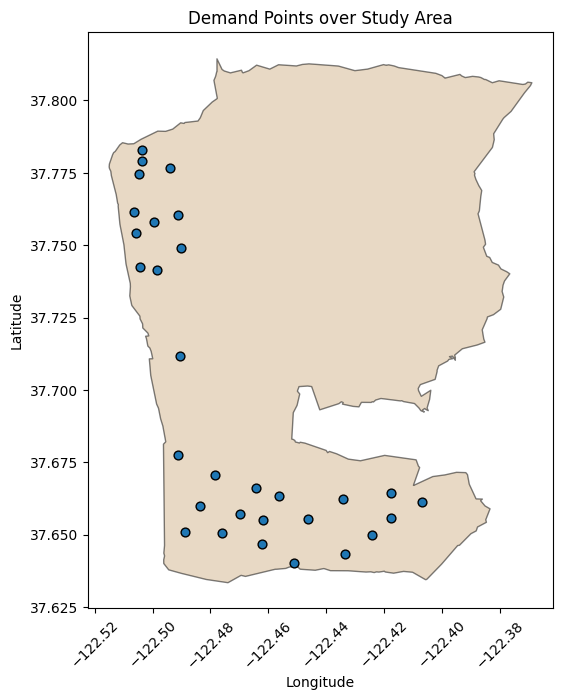

In [5]:
# Extract some part of demand points
target_demand_points = demand_points[:30]
plot_results_on_map(study_area=map_area, clis=target_demand_points)


- (4 pts) An urban planner would like to choose the location $x \in \mathbb{R}^2$ for a new warehouse.
This should be close to $n$ distribution centers located at $y_1, \ldots, y_n \in \mathbb{R}^2$. The objective function to identify the location of the new warehouse is the worst-case distance.
State the optimization problem that helps to identify the proper location.


In [6]:
# Minimum Enclosing Circle implementation
# Source: https://www.nayuki.io/page/smallest-enclosing-circle

def dist(a: Tuple[float, float], b: Tuple[float, float]) -> float:
    return math.hypot(a[0] - b[0], a[1] - b[1])

def is_in_circle(p: Tuple[float, float], c: Tuple[Tuple[float, float], float]) -> bool:
    return dist(p, c[0]) <= c[1] + 1e-12

def circle_center(a: Tuple[float, float], b: Tuple[float, float]) -> Tuple[float, float]:
    return ((a[0] + b[0])/2, (a[1] + b[1])/2)

def circle2(a: Tuple[float, float], b: Tuple[float, float]) -> Tuple[Tuple[float, float], float]:

    center = circle_center(a, b)
    radius = dist(a, center)

    return (center, radius)

def circle3(
        a: Tuple[float, float],
        b: Tuple[float, float],
        c: Tuple[float, float],
        eps: float = 1e-12,
    ) -> Tuple[Tuple[float, float], float] | None:

    ox = (min(a[0], b[0], c[0]) + max(a[0], b[0], c[0])) / 2
    oy = (min(a[1], b[1], c[1]) + max(a[1], b[1], c[1])) / 2

    ax, ay = a[0] - ox, a[1] - oy
    bx, by = b[0] - ox, b[1] - oy
    cx, cy = c[0] - ox, c[1] - oy
    d = (ax*(by - cy) + bx*(cy - ay) + cx*(ay - by)) * 2

    if abs(d) < eps:
        return None

    x = ox + ((ax*ax + ay*ay)*(by - cy) +
              (bx*bx + by*by)*(cy - ay) +
              (cx*cx + cy*cy)*(ay - by)) / d
    
    y = oy + ((ax*ax + ay*ay)*(cx - bx) +
              (bx*bx + by*by)*(ax - cx) +
              (cx*cx + cy*cy)*(bx - ax)) / d
    
    center = (x, y)
    radius = dist(center, a)
    
    return (center, radius)

def minimum_enclosing_circle(points: List[Tuple[float, float]]) -> Tuple[Tuple[float, float], float]:

    points = points.copy()
    random.shuffle(points)

    c = None
    for i, p in enumerate(points):
        if c is None or not is_in_circle(p, c):
            c = (p, 0)
            for j in range(i):
                q = points[j]
                if not is_in_circle(q, c):
                    c = circle2(p, q)
                    for k in range(j):
                        r = points[k]
                        if not is_in_circle(r, c):
                            c = circle3(p, q, r)
    return c



In [7]:
coords = list(zip(target_demand_points["long"], target_demand_points["lat"]))
center, radius = minimum_enclosing_circle(coords)

print("Optimal warehouse location:", center)
print("Worst-case distance:", radius)


Optimal warehouse location: (-122.46257625192575, 37.71618546272906)
Worst-case distance: 0.07827006794655844


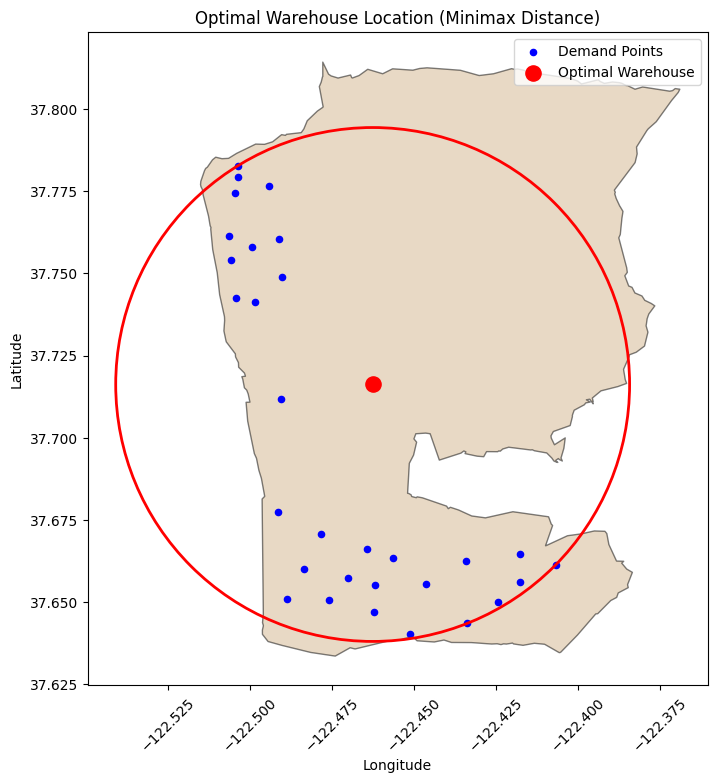

In [8]:
def plot_solution(
        map_area: gpd.GeoDataFrame, 
        demand_points: pd.DataFrame, 
        center: Tuple[float, float],
        radius: float,
    ) -> None:
    
    _, ax = plt.subplots(figsize=(8, 10))
    gpd_demand_points = gpd.GeoDataFrame(geometry=get_points(demand_points))

    # Map area:
    map_area.plot(
        ax=ax, 
        alpha=0.5, 
        edgecolor="k",
        facecolor="tan", 
    )

    # Demand points:
    gpd_demand_points.plot(
        ax=ax, 
        color="blue", 
        markersize=20, 
        label="Demand Points",
    )

    # Warehouse:
    ax.scatter(center[0], center[1], color="red", s=120, label="Optimal Warehouse")

    # Worst-case circle:
    circle = plt.Circle(center, radius, color="red", fill=False, linewidth=2)
    ax.add_patch(circle)

    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude"); ax.legend()
    plt.title("Optimal Warehouse Location (Minimax Distance)")
    plt.xticks(rotation=45); plt.show()

plot_solution(
    center=center,
    radius=radius,
    map_area=map_area, 
    demand_points=target_demand_points, 
)

- (6 pts) Use CVXPy to solve the stated problem. If CVXPy requires reformulation of the resulting problem statement, please do it.
The data for $y_i$ are presented below and taken from the open-source dataset about locations of demand points in San Francisco. See more details [here](https://github.com/huanfachen/Open_source_location_cover_models/tree/master).
Use coordinates $y_i$ from the variable ```target_demand_points``` to identify coordinate of $y$. Plot the obtained optimal position for warehouse in the same plot as demand points.


In [ ]:
# Extract coordinates from your demand points dataframe:
coords = target_demand_points[["long", "lat"]].to_numpy()
n = coords.shape[0]

print(f"Number of demand points: {n}")

# Variables:
x = cp.Variable(2)
t = cp.Variable()

# Constraints:
constraints = [
    cp.norm(x - coords[i], 2) <= t 
    for i in range(n)
]

# Problem: min( t )
problem = cp.Problem(
    objective=cp.Minimize(t), 
    constraints=constraints,
)

problem.solve(solver=cp.ECOS)

print(f"Status: {problem.status}")
print(f"Optimal worst-case distance: {t.value}")
print(f"Optimal warehouse location: {x.value}")


Number of demand points: 30
Status: optimal
Optimal worst-case distance: 0.07827006527967097
Optimal warehouse location: [-122.46257625   37.71618546]


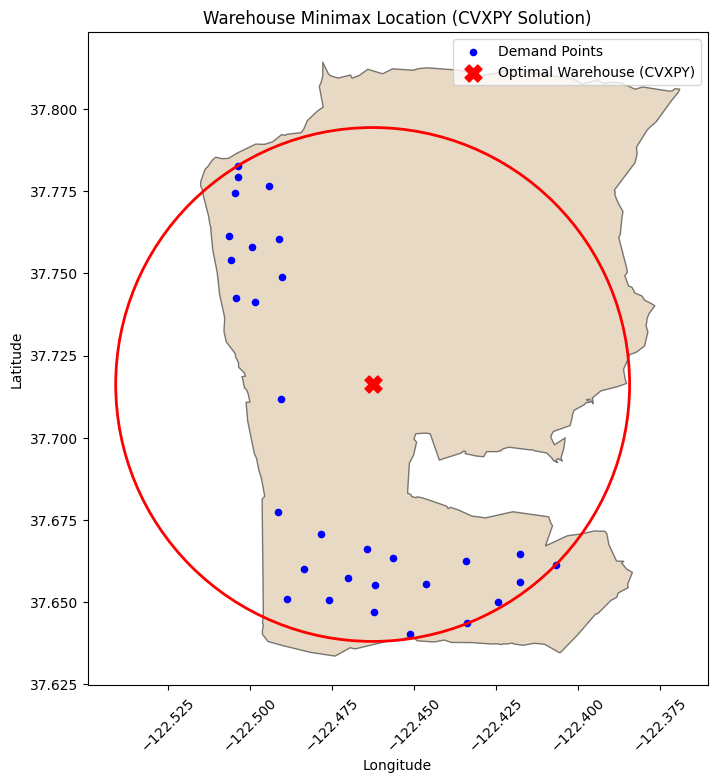

In [10]:
def plot_cvxpy_solution(
        map_area: gpd.GeoDataFrame, 
        demand_points: pd.DataFrame, 
        optimal_x: List[float], 
        t: float,
    ) -> None:

    _, ax = plt.subplots(figsize=(8, 10))

    # Map area:
    map_area.plot(
        ax=ax, 
        alpha=0.5, 
        edgecolor="k",
        facecolor="tan", 
    )

    # Demand points:
    gpd_demand_points = gpd.GeoDataFrame(geometry=get_points(demand_points))
    gpd_demand_points.plot(
        ax=ax, 
        markersize=20, 
        color="blue", 
        label="Demand Points",
    )

    # Warehouse:
    ax.scatter(optimal_x[0], optimal_x[1], color="red", s=150, marker="X", label="Optimal Warehouse (CVXPY)")

    # Worst-case circle:
    circle = plt.Circle(optimal_x, t, color="red", fill=False, linewidth=2)
    ax.add_patch(circle)

    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude"); ax.legend()
    plt.title("Warehouse Minimax Location (CVXPY Solution)")
    plt.xticks(rotation=45); plt.show()

plot_cvxpy_solution(
    t=t.value,
    optimal_x=x.value, 
    map_area=map_area, 
    demand_points=target_demand_points, 
)



### Curiosity: 
How far are this two warehouses defined by the Welzi Algorithm and CVXPY?

Well ... Let's find out! [Source Code](https://www.google.com/search?q=%23+Haversine+formula+to+calculate+the+great-circle+distance+between+two+points+on+the+Earth%3A+in+pytrohn&rlz=1C5CHFA_enIT1123IT1123&oq=%23+Haversine+formula+to+calculate+the+great-circle+distance+between+two+points+on+the+Earth%3A++in+pytrohn&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIHCAEQIRiPAjIHCAIQIRiPAtIBCDMyOTVqMGo5qAIGsAIB8QWj1ah7ufxxyg&sourceid=chrome&ie=UTF-8)

In [11]:
from math import radians, sin, cos, sqrt, asin

# Haversine formula to calculate the great-circle distance between two points on the Earth:
def haversine(p1: np.ndarray, p2: np.ndarray) -> float:

    # Assuming Earth radius in meters: 
    R = 6.371 * 1e6

    lon1, lat1 = p1
    lon2, lat2 = p2

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat/2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))

    return R * c

center_geom = np.array(center)
center_cvx  = np.array(x.value)

dist_haversine = haversine(p1=center_geom, p2=center_cvx)
print(f"Haversine distance (meters): {dist_haversine}")
# Cool :D


Haversine distance (meters): 0.0003355205247448675


- (5 pts) The visualization of the demand points shows that we actually have two groups of the demand points that should be naturally serviced by two different warehouses.
Reformulate the original problem in such a way that it will provide the positions of two warehouses and automatically assign every demand point to the target warehouse. Introduce new variables if needed and try to solve it with CVXPy. To make the problem feasible for CVXPy, you can select the proper way to measure the distances such that the resulting problem becomes Mixed Integer Linear Program.


Two-Warehouse Minimax Problem — Raw Explanation

We now want to place two warehouses instead of one.
Let the warehouse locations be:
    - x_1 ∈ ℝˆ2
    - x_2 ∈ ℝˆ2

The demand points are:
    - y_1, y_2, ..., y_n ∈ ℝˆ2

Each demand point must be assigned to exactly one warehouse.

---------------------------------------------------------------------------

Idea:
The worst-case distance for each point depends on the warehouse it is assigned to.
So we need a mechanism to decide which warehouse serves which point.

Variables:

For every point y_i:
    - z_i_1 = 1 if y_i is assigned to warehouse x_1
    - z_i_2 = 1 if y_i is assigned to warehouse x_2

Constraint:
    - z_i_1 + z_i_2 = 1
This guarantees one unique assignment.

---------------------------------------------------------------------------

Distance measure and MILP:
To make the problem solvable in CVXPY, we use the L1 distance:
    - ||x - y_i||_1 = |x_1 - y_i_1| + |x_2 - y_i_2|
L1 is linearizable → the model becomes a Mixed Integer Linear Program.


Worst-case objective:
We introduce a variable t ∈ ℝˆ2 that upper-bounds all distances.

---------------------------------------------------------------------------

Using Big-M:
* For warehouse 1:
    - ||x_1 - y_i||_1 ≤ t + M(1 - z_i_1)
* For warehouse 2:
    - ||x_2 - y_i||_1 ≤ t + M(1 - z_i_2)

When z_i_1 = 1, the distance to warehouse 1 must be ≤ t.
When z_i_1 = 0, the constraint is inactive.
Same logic for warehouse 2.

---------------------------------------------------------------------------

Final optimization problem:

Variables:
    - x_1, x_2 ∈ ℝˆ2
    - t ∈ ℝ
    - z_i_1, z_i_2 ∈ {0,1}

Objective:
     - min(t)

Subject to:
    - z_i_1, z_i_2 ∈ {0,1}
    - ||x_1 - y_i||_1 ≤ t + M(1 - z_i_1)
    - ||x_2 - y_i||_1 ≤ t + M(1 - z_i_2)

What the model does:
    - Automatically splits the demand points into two groups.
    - Finds the best location x_1 for group 1.
    - Finds the best location x_2 for group 2.
    - Minimizes the worst-case distance across all assignments.


In [31]:
# Extract coordinates from your demand points dataframe:
coords = target_demand_points[["long", "lat"]].to_numpy()
n = coords.shape[0]

print(f"Number of demand points: {n}")

# Variables:
warehouse_1 = cp.Variable(2)
warehouse_2 = cp.Variable(2)
t  = cp.Variable()

# Assignment binaries:
z = cp.Variable((n, 2), boolean=True)

# Big-M constant:
M = 1.0

# Constraints:
constraints = [
    z[i, 0] + z[i, 1] == 1
    for i in range(n)
]

for i in range(n):
    constraints += [
        cp.norm(warehouse_1 - coords[i], 1) <= t + M * (1 - z[i, 0]),
        cp.norm(warehouse_2 - coords[i], 1) <= t + M * (1 - z[i, 1]),
    ]

# Objective: min( t )
objective = cp.Minimize(t)
problem = cp.Problem(
    objective=objective, 
    constraints=constraints,
)

problem.solve(solver=cp.HIGHS)

print("Optimal t:", t.value)
print("Warehouse 1 location:", warehouse_1.value)
print("Warehouse 2 location:", warehouse_2.value)



Number of demand points: 30
Optimal t: 0.05029517299994879
Warehouse 1 location: [-122.50204333   37.7341485 ]
Warehouse 2 location: [-122.45706759   37.66130254]


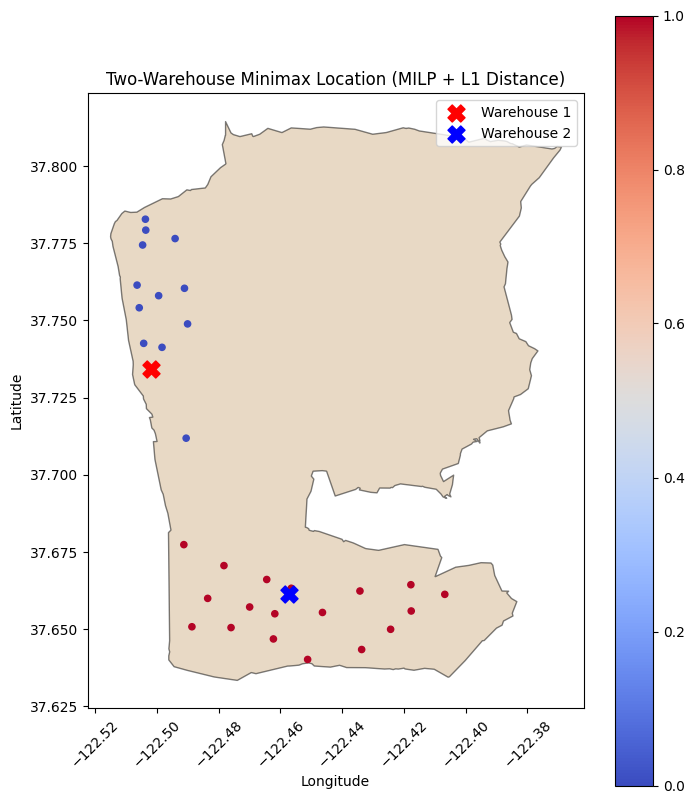

In [33]:
def plot_two_warehouses(
        map_area: gpd.GeoDataFrame, 
        demand_points: pd.DataFrame, 
        warehouse_1: Tuple[float, float],
        warehouse_2: Tuple[float, float],
        assignments: List[int],
    ) -> None:

    _, ax = plt.subplots(figsize=(8,10))

    # Map area:
    map_area.plot(ax=ax, facecolor="tan", alpha=0.5, edgecolor="k")

    # Demand points:
    gdf = gpd.GeoDataFrame(data=demand_points, geometry=get_points(demand_points))
    gdf["cluster"] = assignments
    gdf.plot(
        ax=ax, 
        column="cluster", 
        cmap="coolwarm", 
        markersize=20, 
        legend=True,
    )

    # Warehouse markers:
    ax.scatter(warehouse_1[0], warehouse_1[1], color="red", s=150, marker="X", label="Warehouse 1")
    ax.scatter(warehouse_2[0], warehouse_2[1], color="blue", s=150, marker="X", label="Warehouse 2")

    ax.set_title("Two-Warehouse Minimax Location (MILP + L1 Distance)"); ax.legend()
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    plt.xticks(rotation=45); plt.show()


warehouse_1_opt = warehouse_1.value
warehouse_2_opt = warehouse_2.value
assignments_opt = np.argmax(z.value, axis=1)


plot_two_warehouses(
    map_area=map_area,
    demand_points=target_demand_points,
    warehouse_1=warehouse_1_opt,
    warehouse_2=warehouse_2_opt,
    assignments=assignments_opt,
)

## Task 2 (8 pts)

- In home assignment 2, you solved the task 3 and the result was the convex optimization peroblem. In this task, you have the necessary data and are asked to solve the stated convex optimization problem with cvxpy. If this requires reformulation of the resulting problem statement, please do it.
Take the known data from the attached file and read them with the code below.


In [38]:
# this one is randomly generated; a real one would use the beam geometry
import numpy as np
import scipy.io as sio

def get_value(mat, name):
    value = mat[name]
    return value[0][0] if np.shape(value) == (1, 1) else value

mat = sio.loadmat(FILE_TREATMENT_PLANNING_MAT)

n = get_value(mat, "n")  # number of beams
mtarget = get_value(mat, "mtarget")  # number of tumor or target voxels
mother = get_value(mat, "mother")  # number of other voxels
Atarget = get_value(mat, "Atarget")
Aother = get_value(mat, "Aother")
Bmax = get_value(mat, "Bmax")
Dtarget = get_value(mat, "Dtarget")
Dother = get_value(mat, "Dother")

In [45]:
# Decision Variables:
b = cp.Variable(n)                    # Beam intensities;
e = cp.Variable(mother)               # Excess dose on non-target voxels;

# Dose Expressions:
d_target = Atarget @ b
d_other  = Aother @ b

# Constraints:
constraints = [
    d_target >= Dtarget * np.ones(mtarget),      # Tumor dose requirement;
    d_other - e <= Dother * np.ones(mother),     # Excess dose definition;
    e >= 0,                                      # Excess must be non-negative;
    b >= 0,
    b <= Bmax * np.ones(n)
]

# Objective: minimize sum of squared excess doses
objective = cp.Minimize(cp.sum_squares(e))

problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.ECOS)

print(f"Status: {problem.status}")
print(f"Optimal objective: {problem.value}")
print("Optimal beam intensities b*:", b.value[:10])


Status: optimal
Optimal objective: 0.3080906813899569
Optimal beam intensities b*: [0.00348397 0.04444209 0.01145806 0.03779525 0.03028181 0.0150654
 0.01055951 0.04204321 0.03608454 0.05726893]


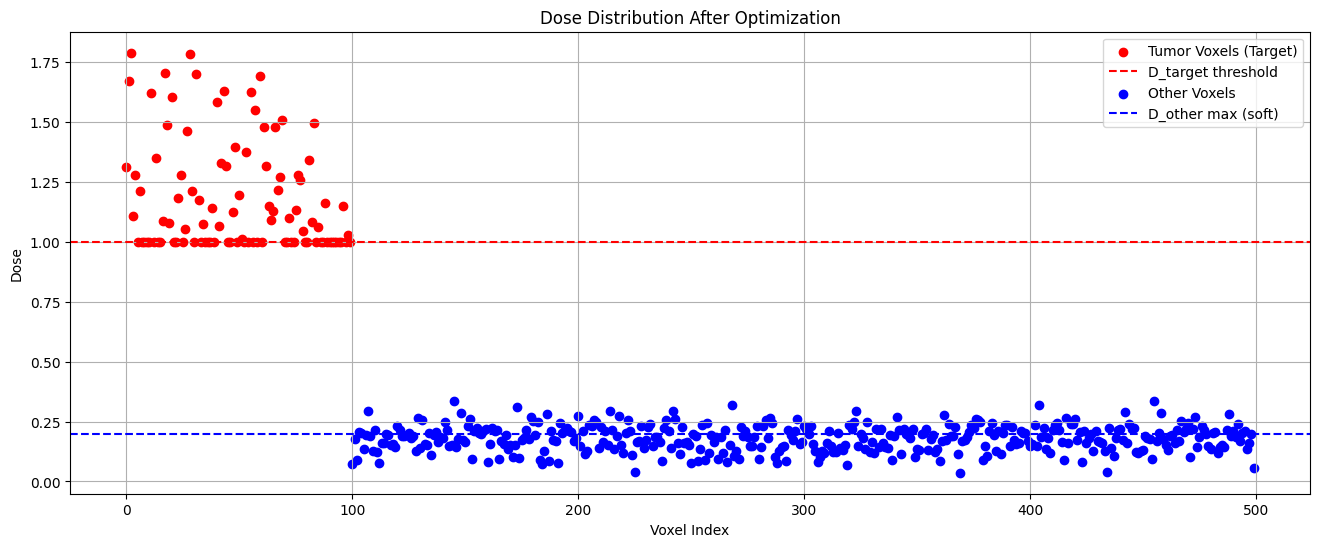

In [47]:
# Final Dose calculations:
d_target_val = (Atarget @ b.value)
d_other_val  = (Aother  @ b.value)

# Plotting
plt.figure(figsize=(16, 6))

plt.scatter(range(mtarget), d_target_val, color="red", label="Tumor Voxels (Target)")
plt.axhline(Dtarget, color="red", linestyle="--", label="D_target threshold")

plt.scatter(range(mtarget, mtarget + mother), d_other_val, color="blue", label="Other Voxels")
plt.axhline(Dother, color="blue", linestyle="--", label="D_other max (soft)")

plt.xlabel("Voxel Index")
plt.ylabel("Dose")
plt.title("Dose Distribution After Optimization")
plt.legend()
plt.grid(True)
plt.show()